# Are word counts correlated with profit margin?
### This is a simplistic experiment but could be more robust

### Software (Python jupyter Pandas) is industry standard



In [ ]:
%pip install "calcbench-api-client[Pandas, Backoff, BeautifulSoup]" tqdm scipy seaborn

In [1]:
import pandas as pd

from tqdm.notebook import tqdm
import qgrid

from scipy.special import expit
import seaborn as sns
from collections import Counter
from typing import Iterable

import calcbench as cb


cb.enable_backoff()
tqdm.pandas(desc="progress")

## Get the documents and build dictionaries of word counts
### Calcbench extracts MD&A from 10-K/Qs

In [ ]:
tickers = cb.tickers(index="SP500")  # can use any list of tickers

In [2]:
#disclosure_embeddings = pd.read_pickle(
#    r"C:\Users\andre\Dropbox (Calcbench)\andrew\sp_500_tokenize_embeddings.pkl"
#)

disclosure_names = ["ManagementsDiscussionAndAnalysis"] # full list available @ 

with tqdm() as progress_bar:
    disclosures = cb.document_dataframe(
        company_identifiers=tickers,
        disclosure_names=disclosure_names,
        all_history=True,
        period_type="annual",
        progress_bar=progress_bar,
        # entire_universe=True,
    )
    
def get_contents(d):
    try:
        return d.get_contents_text()
    except Exception as e:
        print(f"Exception getting {d} \n{e}")


disclosure_contents = disclosures.progress_applymap(
    get_contents, na_action="ignore"
).fillna("")

disclosure_embeddings = disclosure_contents.progress_applymap(
    lambda c: Counter(word.lower() for word in nltk.word_tokenize(c))
)

## Find occurrences of terms

In [84]:
terms = ["inflation", "supply", "inflationary"]

def distance(word_counts: Counter, category_words: Iterable[str]):
    return sum(count for word, count in word_counts.items() if word in category_words)

category_distances = disclosure_embeddings.progress_applymap(
    lambda word_counts: distance(word_counts, terms)
)

progress:   0%|          | 0/14940 [00:00<?, ?it/s]

## Get standardized Profit Margin
### Can get any of the metrics from https://www.calcbench.com/home/standardizedmetrics

In [8]:

metric = "GrossProfitMargin"  # Can use any of the calcbench standardized metrics

profit_margin = cb.standardized_data(
    company_identifiers=tickers,
    metrics=[metric],
    all_history=True,
    period_type="annual",
)[metric]

In [10]:
SIC_code = cb.standardized_data(
    company_identifiers=tickers,
    metrics=["SIC_code"],
    all_history=True,
    period_type="annual",
)

In [61]:
two_digit_SIC_codes = pd.to_numeric(
    SIC_code["SIC_code"].iloc[0] // 100, downcast="integer"
).astype(str)
two_digit_SIC_codes.name = "SIC_Code"

In [14]:
md_a_diff = (
    category_distances.ManagementsDiscussionAndAnalysis
    - category_distances.ManagementsDiscussionAndAnalysis.shift()
)

In [21]:
profit_margin_change = profit_margin - profit_margin.shift()

In [90]:
md_a_diff

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,ALXN,AMAT,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,ANTM,AON,AOS,APA,APD,APH,APTV,ARE,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BAX,BBY,BDX,BEN,BFA,BIIB,BIO,BK,BKNG,BKR,BLK,BLL,BMS,BMY,BR,BRK,BSX,BWA,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDNS,CDW,CE,CERN,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COG,COO,COP,COST,CPB,CPRT,CRL,CRM,CSCO,CSX,CTAS,CTLT,CTSH,CTVA,CTXS,CVS,CVX,CZR,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISCA,DISH,DLR,DLTR,DOV,DOW,DPZ,DRE,DRI,DTE,DUK,DVA,DVN,DXC,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,EMN,EMR,ENPH,EOG,EQIX,EQR,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FB,FBHS,FCX,FDX,FE,FFIV,FIS,FISV,FITB,FLT,FMC,FOX,FRT,FTNT,FTV,GD,GE,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GPC,GPN,GPS,GRMN,GS,GWW,HAL,HAS,HBAN,HBI,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INFO,INTC,INTU,IP,IPG,IPGP,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JCI,JKHY,JNJ,JNPR,JPM,K,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,KSU,L,LB,LDOS,LEG,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUMN,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOS,MPC,MPWR,MRK,MRO,MS,MSCI,MSFT,MSI,MTB,MTD,MU,MXIM,MYL,NCLH,NDAQ,NEE,NEM,NFLX,NI,NKE,NLOK,NLSN,NOC,NOV,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NXPI,O,ODFL,OKE,OMC,ORCL,ORLY,OTIS,OXY,PAYC,PAYX,PBCT,PCAR,PEAK,PEG,PENN,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,POOL,PPG,PPL,PRGO,PRU,PSA,PSX,PTC,PVH,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,SBAC,SBUX,SCHW,SEE,SHW,SIVB,SJM,SLB,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TWTR,TXN,TXT,TYL,UA,UAL,UDR,UHS,ULTA,UNH,UNM,UNP,UPS,URI,USB,V,VFC,VIAC,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WLTW,WM,WMB,WMT,WRB,WRK,WST,WU,WY,WYNN,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
period,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [91]:
d = (
    pd.DataFrame(
        data={
            "profit_margin_change": expit(profit_margin_change.stack()),
            "inflation_count_change": expit(md_a_diff.shift(-1)).stack(),
        }
    )
    .swaplevel()
    .sort_index()
)

## Correlation of period profit margin change and presence inflation terms

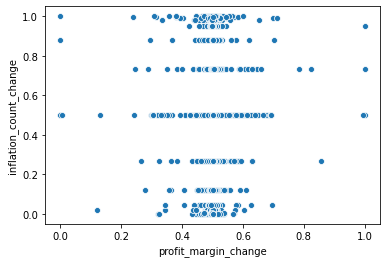

In [92]:
sns.scatterplot(x="profit_margin_change", y="inflation_count_change", data=d)

## How has term count changed over time?

In [75]:
total_word_counts = disclosure_embeddings.progress_applymap(lambda w: sum(w.values()))
tf_document_length = category_distances / total_word_counts
industry_averages = tf_document_length.groupby(by=group, axis=1).mean()

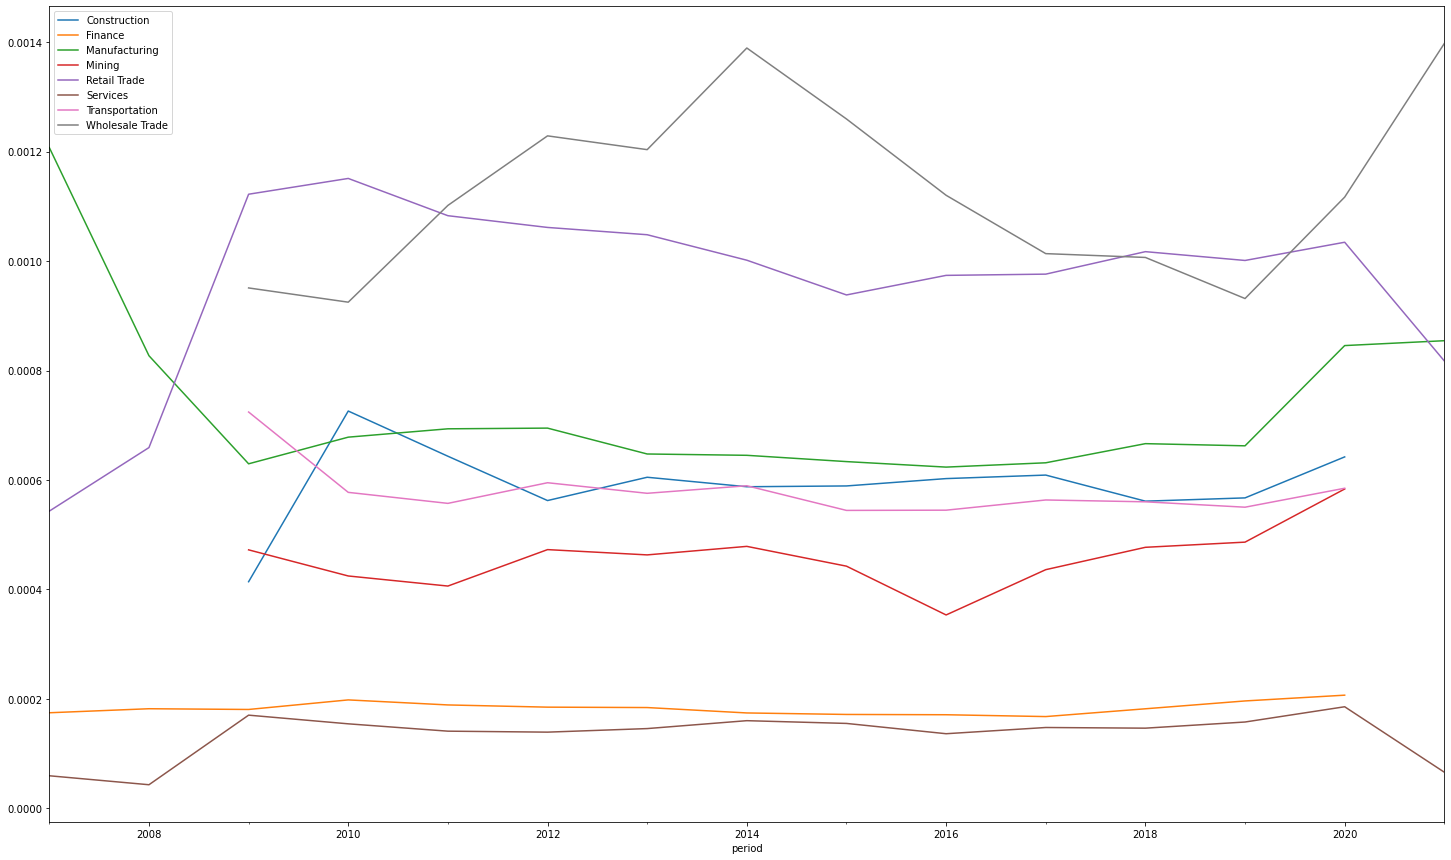

In [86]:
industry_averages.plot(figsize=(25, 15))

In [ ]:
def group(c):
    try:
        two_digit_SIC_code = int(two_digit_SIC_codes[c[1]])
    except KeyError:
        return None
    else:
        if two_digit_SIC_code < 9:
            return "Agriculture"
        elif 10 <= two_digit_SIC_code <= 14:
            return "Mining"
        elif 15 <= two_digit_SIC_code <= 17:
            return "Construction"
        elif 20 <= two_digit_SIC_code <= 39:
            return "Manufacturing"
        elif 40 <= two_digit_SIC_code <= 49:
            return "Transportation"
        elif 50 <= two_digit_SIC_code <= 51:
            return "Wholesale Trade"
        elif 52 <= two_digit_SIC_code <= 59:
            return "Retail Trade"
        elif 60 <= two_digit_SIC_code <= 67:
            return "Finance"
        elif 70 <= two_digit_SIC_code <= 89:
            return "Services"